In [3]:
import pandas as pd
import numpy as np
from statsmodels.formula.api import ols
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import seaborn as sns


pd.options.display.max_columns = 60

## Data

In [4]:
data = pd.read_csv('survey.csv')
data.drop(columns='Informazioni cronologiche', inplace=True)

oldcols = data.columns

data.dropna(inplace=True)
df = pd.DataFrame()
for n,i in enumerate(data.columns):
    df['ans_' + str(n)] = pd.Categorical(data[i]).codes

df['ans_0'] = df['ans_0'].apply(lambda x: None if x==2 else x)
df.dropna(inplace=True)

cols = ['ans_' + str(i) for i in range(2,9)]
for i in cols:
    df[i] = df[i] + 1
eng = df.loc[df['ans_0']==0].sample(len(df.loc[df['ans_0']==1]))
ita = df.loc[df['ans_0']==1]
balanced_df = pd.concat([ita,eng])


In [5]:
def dummy(dataframe):
    cols = list(dataframe.columns)
    cols.remove('ans_0')
    cols.remove('ans_1')
    tmp = pd.DataFrame(dataframe['ans_0'])
            
    for i in cols:
        tmp = tmp.join(pd.get_dummies(dataframe[i], prefix=i))
    
    return tmp

In [6]:
dummy_df = dummy(balanced_df)

In [7]:
def plot_ans(dataframe):
    fig, axis = plt.subplots(2,4,figsize=(30,16))
    for i in range(8):
        if i % 2 == 0:
            k = 1
            j = i//2
        else:
            k = 0
            j = (i - 1)//2
            
        sns.boxenplot(x='ans_0', y='ans_{}'.format(i+2), data=dataframe, ax=axis[k, j])
        axis[k,j].set_title(oldcols[i+2][:17])
        axis[k,j].set_ylim(1,5)
        axis[k,j].set_xticklabels(['Inglesi', 'Italiani'], fontsize=14)
        axis[k,j].set_yticks(range(1,6))
        axis[k,j].set_xlabel('Nazionalità')
        axis[k,j].set_ylabel('Level of Offence')
        axis[k,j].tick_params(bottom=False, left=False)
        sns.despine(left=True, bottom=True)

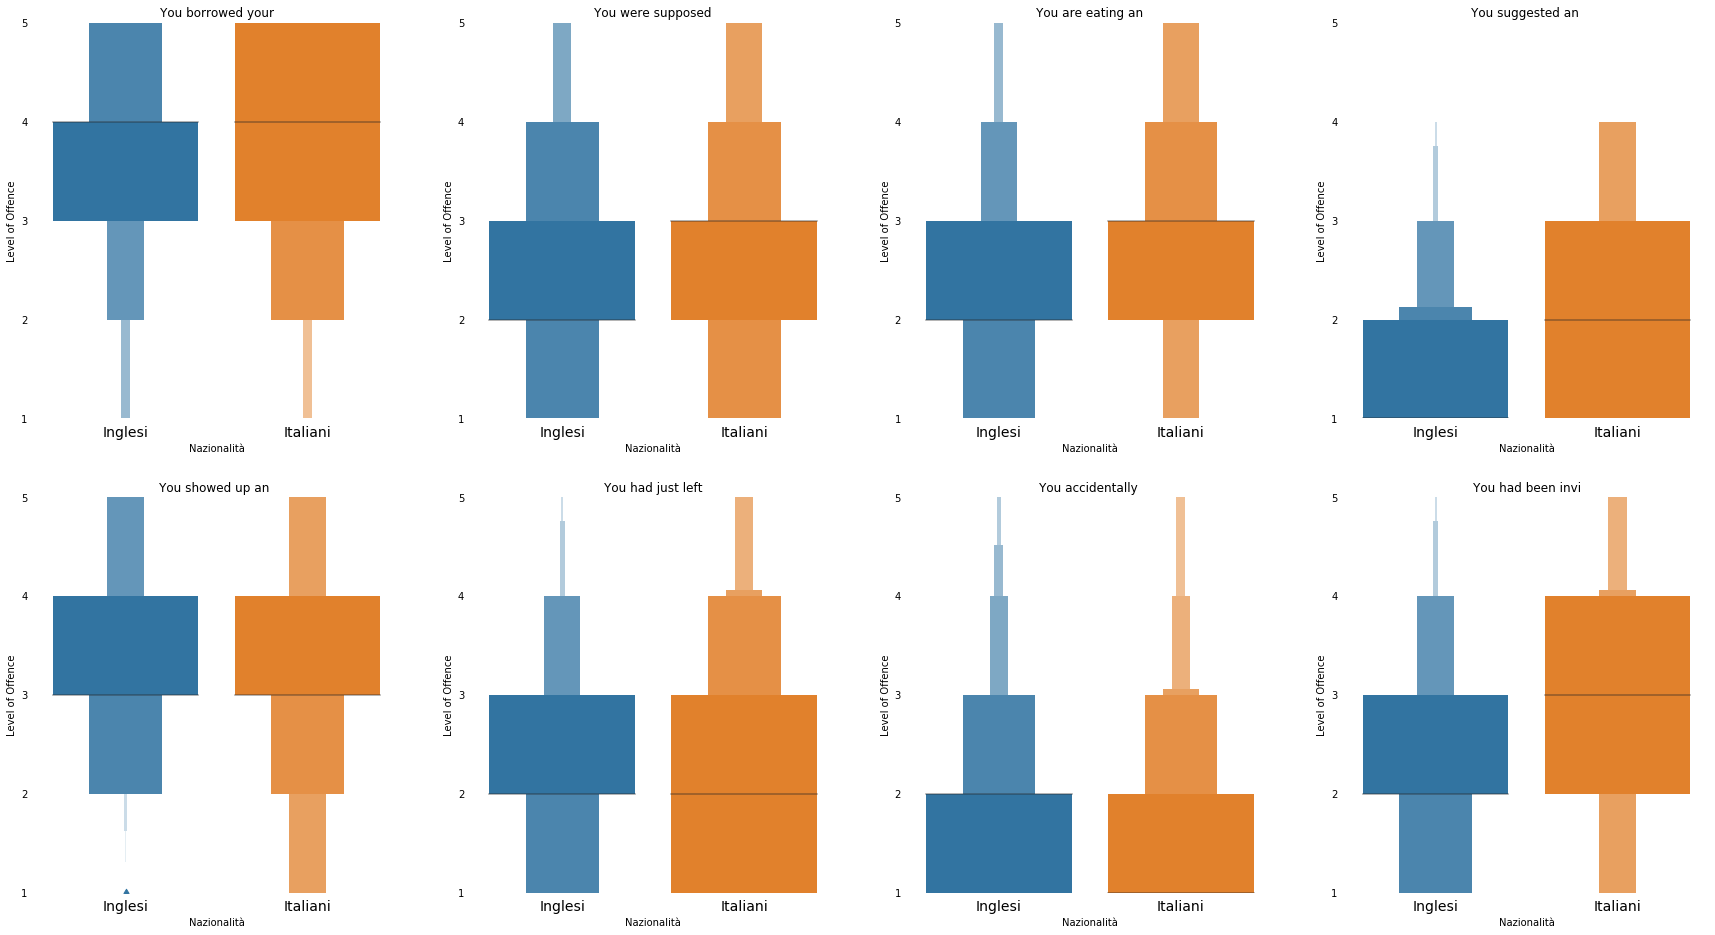

In [8]:
plot_ans(balanced_df)

In [9]:
def split_df(dataframe):
    if 'ans_0' in dataframe.columns:
        x = dataframe.drop(columns=['ans_0'])
        y = dataframe['ans_0']
    else:
        y = df_2['ans_0']
    if 'ans_1' in dataframe.columns:
        x.drop(columns=['ans_1'], inplace=True)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=45)
    return x, y, x_train, x_test, y_train, y_test

In [10]:
x, y, x_train, x_test, y_train, y_test = split_df(dummy_df)

## Anova

In [26]:
italians = df.loc[df['ans_0'] == 1].drop(columns=['ans_0', 'ans_1']).mean(axis=1)
english = df.loc[df['ans_0'] == 0].drop(columns=['ans_0', 'ans_1']).sample(len(italians)).mean(axis=1)

In [27]:
stats.f_oneway(italians, english)

F_onewayResult(statistic=14.105476808668739, pvalue=0.0002055137147540993)

## Logistic Regression

In [13]:
lr = LogisticRegression( solver='lbfgs', multi_class='auto')
lr.fit(x_train, y_train)

predictions = lr.predict(x_test)
accuracy_score(y_test, predictions)

0.6792452830188679

In [14]:
confusion_matrix(y_test, predictions)

array([[44, 14],
       [20, 28]])

## K-Means

In [16]:
kmeans = KMeans(n_clusters=2)
y_kmeans = kmeans.fit_predict(x)
confusion_matrix(y, y_kmeans)

array([[83, 77],
       [64, 96]])

In [17]:
accuracy_score(y, y_kmeans)

0.559375

## K-Nearest Neighbours

In [34]:
from sklearn.neighbors import RadiusNeighborsClassifier

neigh = RadiusNeighborsClassifier(radius=3.0)
neigh.fit(x_train, y_train)
results = neigh.predict(x_test)
accuracy_score(y_test, results)

0.6981132075471698

In [35]:
confusion_matrix(y_test, results)

array([[47, 11],
       [21, 27]])